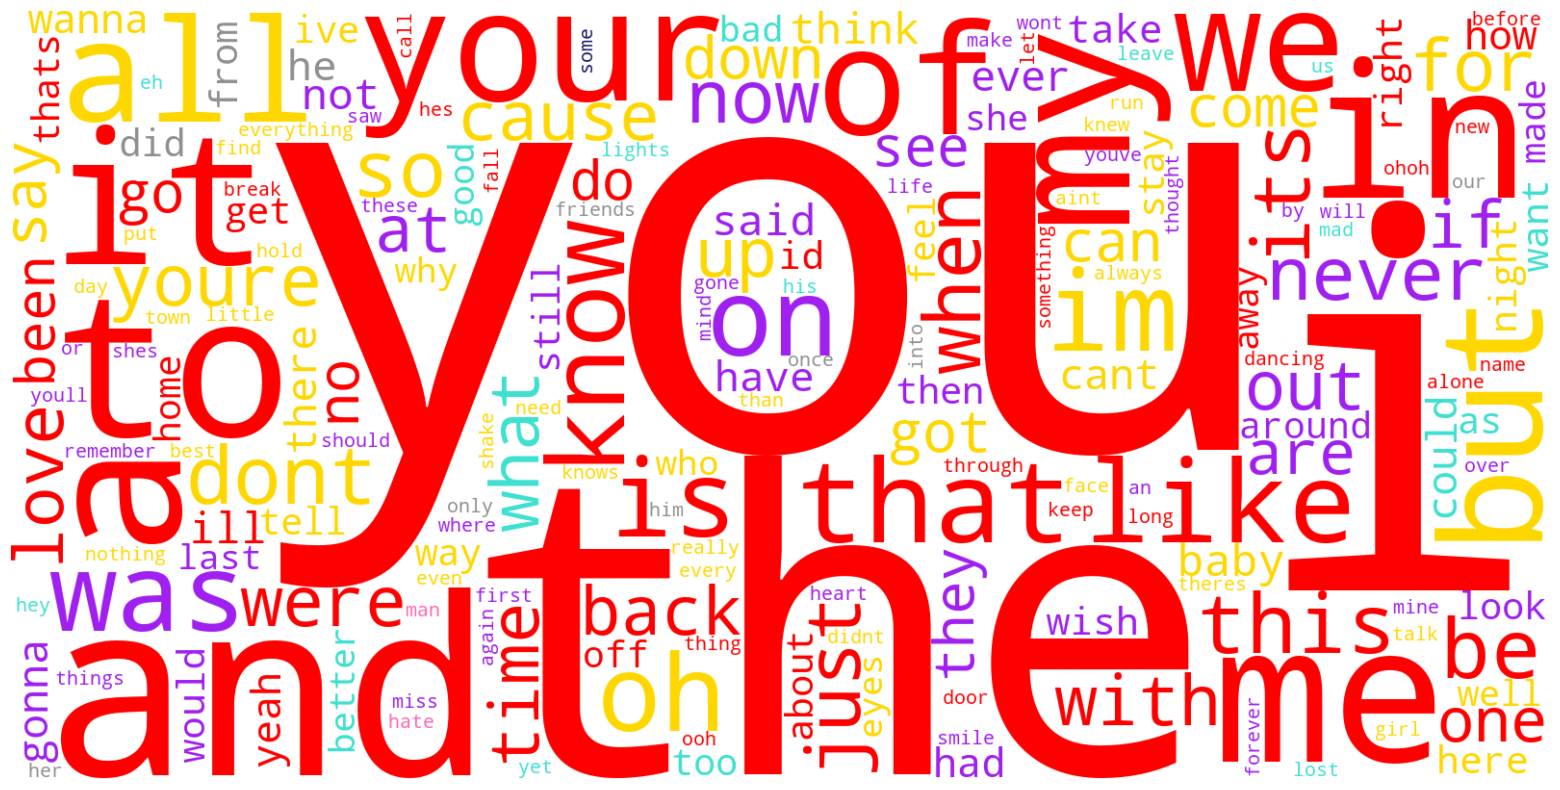

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import string
from collections import Counter
import numpy as np

df = pd.read_csv('Taylor_Swift_Albums.csv', encoding='ISO-8859-1')

# Normalize album names by removing "(Taylor's Version)"
df['Album'] = df['Album'].str.replace(" (Taylor's Version)", '', regex=False)

# Prepare structures for counting
album_word_counts = {}
word_album_map = {}

# Count words per album
for _, row in df.iterrows():
    album = row['Album']
    lyrics = row['Lyrics'].lower()
    lyrics = lyrics.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    words = lyrics.split()

    if album not in album_word_counts:
        album_word_counts[album] = Counter()
    album_word_counts[album].update(words)

    for word in set(words):
        if word not in word_album_map:
            word_album_map[word] = Counter()
        word_album_map[word][album] += 1

# Aggregate total counts
total_counts = sum(album_word_counts.values(), Counter())

# Identify which album each word is most associated with
word_color_map = {word: word_album_map[word].most_common(1)[0][0] for word in total_counts}

# Custom color palette based on your preferences
custom_album_colors = {
    "Taylor Swift": "#98FF98",   # Mint green
    "Fearless": "#FFD700",       # Gold
    "Speak Now": "#A020F0",      # Purple
    "Red": "#FF0000",            # Red
    "1989": "#40E0D0",           # Turquoise
    "Reputation": "#000000",     # Black
    "Lover": "#FF69B4",          # Pink
    "Folklore": "#B4A89C",       # Beige grey
    "Evermore": "#FFFDD0",       # Cream
    "Midnights": "#191970",      # Navy
    "TTPD": "#909090"            # Dark grey
}

# Define color function for word cloud
def updated_color_func(word, *args, **kwargs):
    album = word_color_map.get(word, "Taylor Swift")
    hex_color = custom_album_colors.get(album, "#000000")  # Default to black if not matched
    return hex_color

# Generate the word cloud
wordcloud = WordCloud(
    width=1600,
    height=800,
    background_color='white',
    color_func=updated_color_func
).generate_from_frequencies(total_counts)

# Plot the word cloud
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
#plt.title('Taylor Swift Lyrics: Most Common Words by Album Color', fontsize=20)
plt.show()

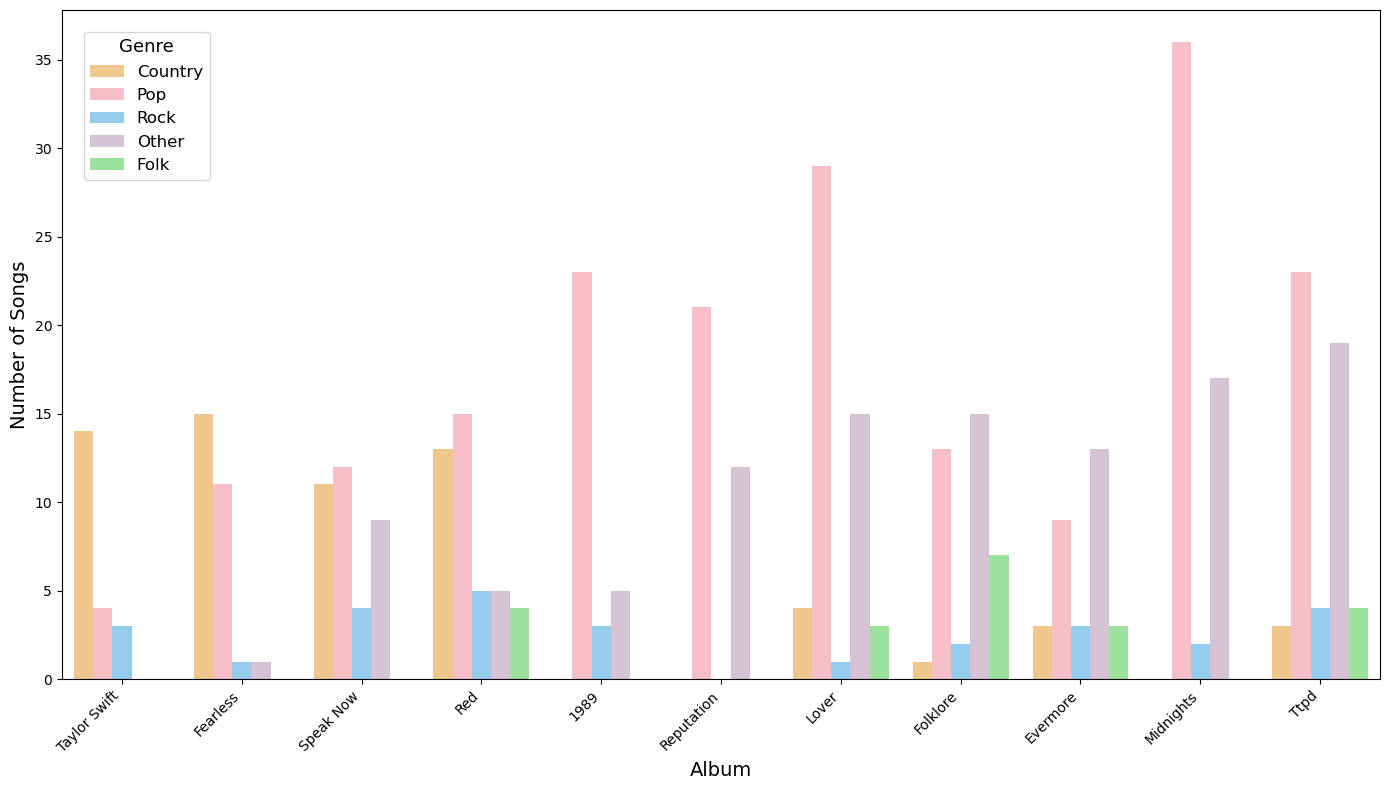

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('Taylor_Swift_Albums.csv', encoding='ISO-8859-1')

# Standardize album names and genre formatting
df['Album'] = df['Album'].str.strip().str.title()
df['Genre'] = df['Genre'].astype(str).str.lower().str.strip()
df['Genre List'] = df['Genre'].str.split(',')

# Explode the genres into separate rows
df_exploded = df.explode('Genre List')
df_exploded['Genre List'] = df_exploded['Genre List'].str.strip()

# Define refined genre mapping function
def map_genre_to_broad(genre):
    genre = genre.strip().lower()
    if 'pop' in genre and genre != 'country pop':
        return 'Pop'
    elif genre in ['country', 'country pop', 'country rock']:
        return 'Country'
    elif genre in ['folk', 'folk pop', 'indie folk', 'singer-songwriter', 'acoustic']:
        return 'Folk'
    elif genre in ['rock', 'alternative rock', 'post-grunge', 'soft rock', 'alternative', 'new wave']:
        return 'Rock'
    else:
        return 'Other'

# Apply genre simplification
df_exploded['Refined Genre'] = df_exploded['Genre List'].apply(map_genre_to_broad)

# Count number of songs per genre per album
refined_genre_album_counts = df_exploded.groupby(['Album', 'Refined Genre']).size().reset_index(name='Count')

# Specify the proper release order
release_order = [
    "Taylor Swift", "Fearless", "Speak Now", "Red", "1989", "Reputation",
    "Lover", "Folklore", "Evermore", "Midnights", "Ttpd"
]
refined_genre_album_counts['Album'] = pd.Categorical(refined_genre_album_counts['Album'], categories=release_order, ordered=True)
refined_genre_album_counts = refined_genre_album_counts.sort_values(['Album', 'Count'], ascending=[True, False])

# Define custom pretty colors for genres
pretty_palette = {
    'Pop': '#FFB6C1',       # Light pink
    'Country': '#ffca7d',   # Pastel Orange
    'Folk': '#90EE90',      # Light green
    'Rock': '#87CEFA',      # Light sky blue
    'Other': '#D8BFD8'      # Thistle
}
# Plot the refined genre distribution by album
plt.figure(figsize=(14, 8))
sns.barplot(
    data=refined_genre_album_counts,
    x='Album',
    y='Count',
    hue='Refined Genre',
    palette=pretty_palette
)
plt.xlabel('Album', fontsize=14)
plt.ylabel('Number of Songs', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(
    title='Genre',
    loc='upper left',
    bbox_to_anchor=(0.01, 0.98),
    prop={'size': 12},
    title_fontsize=13
)
plt.tight_layout()
plt.show()

Geocoding locations... This may take a few minutes.


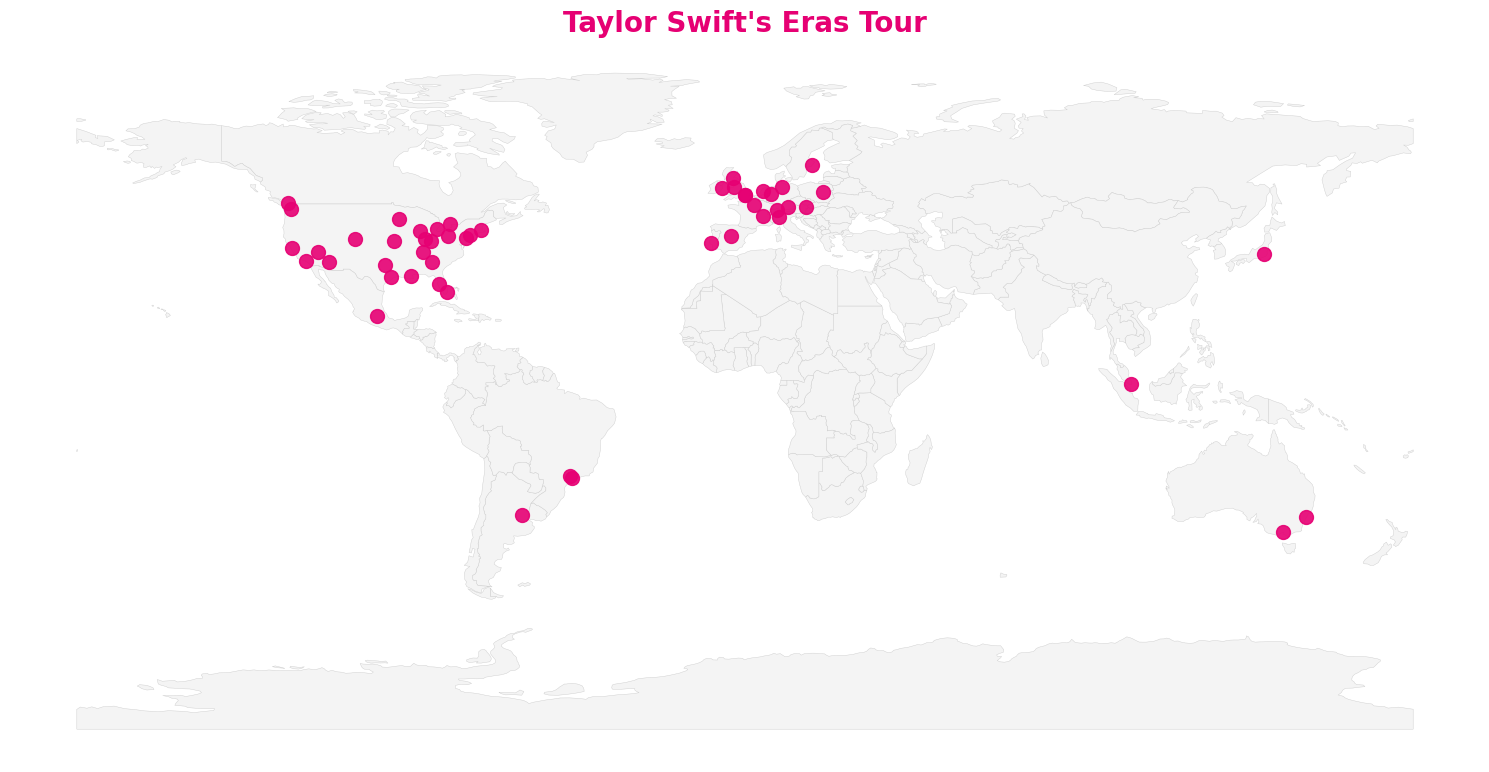

In [45]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

# Step 1: Load the tour data
df = pd.read_csv("eras tour dates.csv", encoding="ISO-8859-1")
df["Full Location"] = df["City"] + ", " + df["country"]

# Step 2: Setup geocoder with error handling
geolocator = Nominatim(user_agent="eras_tour_mapper", timeout=10)
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

def safe_geocode(location):
    try:
        return geocode(location)
    except:
        return None

# Step 3: Geocode the cities
print("Geocoding locations... This may take a few minutes.")
df["location"] = df["Full Location"].apply(safe_geocode)
df["point"] = df["location"].apply(lambda loc: (loc.latitude, loc.longitude) if loc else (None, None))
df = df.dropna(subset=["point"])

# Step 4: Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(
        [pt[1] for pt in df["point"]],
        [pt[0] for pt in df["point"]]
    ),
    crs="EPSG:4326"
)

# Step 5: Load the world map shapefile (downloaded manually from Natural Earth)
world = gpd.read_file("ne_110m_admin_0_countries.shp")

# Step 6: Plot the minimalist dot map
fig, ax = plt.subplots(figsize=(15, 10))

# World map styling
world.plot(ax=ax, color="#f4f4f4", edgecolor="#cccccc", linewidth=0.3)

# Plot crimson dots only
gdf.plot(ax=ax, color="#e60073", markersize=100, alpha=0.9)

# Clean, bold title
plt.title("Taylor Swift's Eras Tour", fontsize=20, fontweight='bold', color="#e60073")

# Aesthetic clean-up
plt.axis("off")
plt.tight_layout()

# Save high-resolution output
plt.savefig("eras_tour_map_clean_dots.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# Optional: Save geocoded results
df.to_csv("geocoded_eras_tour.csv", index=False)